### Thymus human spatial atlas Step 1 - dissociated dataset curation
This notebook is used to read all disssociated data before integration and perform basic QC.  
*all datasets were subjected to "supp removal" with cellbender

Authour - Nadav Yayon, 2023

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import scanpy as sc
import scrublet as sl
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import anndata as ad
import scvi
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map='viridis')
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 louvain==0.7.1 pynndescent==0.5.7


In [34]:
Path = '' # Removed the actual path, as it is irrelevant
os.chdir(Path)
meta = pd.read_csv('') # Removed the actual path, as it is irrelevant
meta.columns = meta.columns.str.strip()

# Nuclei data demultiplexing 

In [ ]:
# take nuclei demultiplex samples metadata from Souporcell
os.chdir('') # Removed the actual path, as it is irrelevant
nuclei = meta['type']=='nuclei'
metaPlex = meta.iloc[np.where(nuclei)[0],:].reset_index()
metaPlex['library']

In [5]:
# remove multiplexed libraries from original meta
meta = meta.iloc[np.where(nuclei==False)[0],:]
meta = meta.reset_index()
meta

,index,library,sample,path_GEX,donor,SangerID,Age1,Age_group2,Sex,sort,...,Age2,SampleID_TCRab,path_TCRab,mapped_with,SampleID_TCRgd,path_TCRgd,SampleID_BCR,path_BCR,CITE_library,CITE_Path
0,0,F23_TH_45P,FCAImmP7198634,/nfs/team205/vk8/irods_data/09_thymus/cellbend...,F23,NaN,-29,fetal,M,45P,...,11w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,F23_TH_45N,FCAImmP7198635,/nfs/team205/vk8/irods_data/09_thymus/cellbend...,F23,NaN,-29,fetal,M,45N,...,11w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,F64_TH_TOT_5GEX_1,FCAImmP7851890,/nfs/team205/vk8/irods_data/09_thymus/cellbend...,F64,NaN,-29,fetal,M,TOT,...,11w,FCAImmP7851882,warehouse/cellgeni/tic-1144/E-MTAB-8581/VDJ/F6...,CellRanger,NaN,NaN,NaN,NaN,NaN,NaN
3,3,F64_TH_TOT_5GEX_2,FCAImmP7851891,/nfs/team205/vk8/irods_data/09_thymus/cellbend...,F64,NaN,-29,fetal,M,TOT,...,11w,FCAImmP7851883,warehouse/cellgeni/tic-1144/E-MTAB-8581/VDJ/F6...,CellRanger,NaN,NaN,NaN,NaN,NaN,NaN
4,4,F45_TH_45P,FCAImmP7579218,/nfs/team205/vk8/irods_data/09_thymus/cellbend...,F45,NaN,-28,fetal,NaN,45P,...,12w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,78,GEX12,sample12,/nfs/team205/ny1/CITE_Seq/Large_Data/RNA_part/...,TSC-CT10,NaN,3,infant,m,CD3P,...,3m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,79,TA13072429,U48-THY-0-SC-EPCP-2_5GEX,/nfs/team205/vk8/irods_data/09_thymus/starsolo...,U48,U48-THY-0-SC-1,6,infant,m,MACS,...,6m,TA13072432,lustre/scratch126/cellgen/cellgeni/tickets/tic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,80,TA13072428,U48-THY-0-SC-EPCP-1_5GEX,/nfs/team205/vk8/irods_data/09_thymus/starsolo...,U48,U48-THY-0-SC-1,6,infant,m,MACS,...,6m,TA13072431,lustre/scratch126/cellgen/cellgeni/tickets/tic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,81,TA13072427,U48-THY-0-SC-1_5GEX,/nfs/team205/vk8/irods_data/09_thymus/starsolo...,U48,U48-THY-0-SC-1,6,infant,m,TOT,...,6m,TA13072430,lustre/scratch126/cellgen/cellgeni/tickets/tic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## This Part is about nuceli de multiplexing (libraries were demultiplexed by Souporcell)

In [7]:
# read multiplexed and run scrublet 
X = pd.DataFrame(np.empty((0,0)))
obs = pd.DataFrame(index=X.index)
var = pd.DataFrame(index=X.columns) 
X = X.values

AnnPlex = ad.AnnData(X=X, obs=obs, var=var)
for idx,f in enumerate(metaPlex.iloc[:,1]):
    results_file = metaPlex['path_GEX'][idx]+'/'+metaPlex['library'][idx]+'_filtered.h5'
    print(results_file)
    adata = sc.read_10x_h5(results_file)
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=400)
    print(metaPlex['library'][idx])
    print(adata.shape)
    # add metadata 
    adata.obs['barcode'] = adata.obs.index
    adata.obs['sample_barcode'] = metaPlex['sample'][idx] + '-' + adata.obs.index
    adata.obs.index = metaPlex['library'][idx] + '-' + adata.obs.index
    adata.obs['batch'] = idx+meta.shape[0] # fix batch 
    adata.obs['chemistry'] = metaPlex['method'][idx]
    adata.obs['age_group'] = metaPlex['Age_group2'][idx]
    adata.obs['age_numeric'] = metaPlex['Age1'][idx]
    adata.obs['sampleID_TCRab'] = metaPlex['SampleID_TCRab'][idx]
    adata.obs['path_TCRab'] = metaPlex['path_TCRab'][idx]
    adata.obs['type'] = metaPlex['type'][idx]
    adata.obs['study'] = metaPlex['Study'][idx]
    adata.obs['sample'] = metaPlex['sample'][idx]
    adata.obs['enrichment'] = metaPlex['sort'][idx]
    adata.obs['donor'] = metaPlex['donor'][idx]
        


    # doublet detection     
    sc.external.pp.scrublet(adata)
    # adata = adata[adata.obs.doublet_score < 0.3, :]
    AnnPlex = ad.concat([AnnPlex,adata],join='outer')
    
    print(AnnPlex)
AnnPlex.obs.index.names = ['barcode']

In [8]:
# qc 
AnnPlex.var['mt'] = AnnPlex.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(AnnPlex, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
AnnPlex.obs
sc.pl.violin(AnnPlex, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.1, multi_panel=True)

In [9]:
AnnPlex.var_names_make_unique()
supercell = pd.read_csv("/lustre/scratch117/cellgen/team205/sharedData/ny1/22-05-24-5sample-souporcell-nuclei-cellbender/combined/clusters.tsv", delimiter = '\t')
supercell.set_index(['barcode'],drop=True,inplace=True)
supercell.head()

In [10]:
AnnPlex.obs = AnnPlex.obs.merge(supercell, left_index=True, right_index=True)
AnnPlex.obs.head()

In [11]:
# cells that are assigned to both donors are probably doublets so remove
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '2/0', :]
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '2/1', :]
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '0/1', :]
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '0/2', :]
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '1/2', :]
AnnPlex = AnnPlex[AnnPlex.obs.assignment != '1/0', :]

AnnPlex.obs.assignment

barcode
TA12303448-GACGCTGCACACGGTC    0
TA12303448-AGGTCTAAGGCACTCC    0
TA12303448-GTGCACGGTCGAGCAA    0
TA12303448-GCACATATCCTGGGAC    0
TA12303448-GTTGAACAGTTCATGC    0
                              ..
TA12303451-TCTCCGAAGATGAAGG    1
TA12303451-TTCAGGATCTAGTGTG    1
TA12303451-CGAAGGAGTCCTCATC    0
TA12303451-TACCCGTGTGGCTGAA    1
TA12303451-GTGCACGGTTAGAGAT    1
Name: assignment, Length: 50551, dtype: object

In [13]:
# deplex libraries 
AnnDepPlex = AnnPlex.copy()
normlib = ['TA12303447','TA12303448','TA12303449']
donors = ['U09_n', 'U11', 'Z6']

assign0 = AnnPlex[AnnPlex.obs['donor'] == donors[0]].obs.assignment.value_counts().idxmax()
assign1 = AnnPlex[AnnPlex.obs['donor'] == donors[1]].obs.assignment.value_counts().idxmax()
assign2 = AnnPlex[AnnPlex.obs['donor'] == donors[2]].obs.assignment.value_counts().idxmax()
assign = [assign0, assign1, assign2]

Age0 = AnnPlex[AnnPlex.obs['donor'] == donors[0]].obs.age_numeric.value_counts().idxmax()
Age1 = AnnPlex[AnnPlex.obs['donor'] == donors[1]].obs.age_numeric.value_counts().idxmax()
Age2 = AnnPlex[AnnPlex.obs['donor'] == donors[2]].obs.age_numeric.value_counts().idxmax()

AnnDepPlex.obs['donor'] = AnnDepPlex.obs['assignment'].astype("category")
AnnDepPlex.obs['donor'] = AnnDepPlex.obs['donor'].map({assign[0]:donors[0],assign[1]:donors[1],assign[2]:donors[2],})
AnnDepPlex.obs['age_numeric'] = AnnDepPlex.obs['assignment'].astype("category")
AnnDepPlex.obs['age_numeric'] = AnnDepPlex.obs['age_numeric'].map({assign[0]:Age0,assign[1]:Age1,assign[2]:Age2,})
AnnDepPlex.obs['age_numeric']

barcode
TA12303448-GACGCTGCACACGGTC    5
TA12303448-AGGTCTAAGGCACTCC    5
TA12303448-GTGCACGGTCGAGCAA    5
TA12303448-GCACATATCCTGGGAC    5
TA12303448-GTTGAACAGTTCATGC    5
                              ..
TA12303451-TCTCCGAAGATGAAGG    6
TA12303451-TTCAGGATCTAGTGTG    6
TA12303451-CGAAGGAGTCCTCATC    5
TA12303451-TACCCGTGTGGCTGAA    6
TA12303451-GTGCACGGTTAGAGAT    6
Name: age_numeric, Length: 50551, dtype: category
Categories (3, object): ['5', '6', '30']

In [14]:
del AnnPlex

In [15]:
# qc
# mitochondrial genes
AnnDepPlex.var['mt'] = AnnDepPlex.var_names.str.startswith('MT-') 
# ribosomal genes
AnnDepPlex.var['ribo'] = AnnDepPlex.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
AnnDepPlex.var['hb'] = AnnDepPlex.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(AnnDepPlex, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
AnnDepPlex.obs

In [16]:
mito_genes = AnnDepPlex.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
AnnDepPlex.obs['percent_mt2'] = np.sum(
    AnnDepPlex[:, mito_genes].X, axis=1).A1 / np.sum(AnnDepPlex.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
AnnDepPlex.obs['n_counts'] = AnnDepPlex.X.sum(axis=1).A1

In [21]:
sc.pl.violin(AnnDepPlex, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.01, multi_panel=True)

# Read all other single cell data and merge with demultiplexd nuclei 

In [23]:
# read the rest of the libraries and run scrublet 
import warnings 
warnings.simplefilter("ignore")

In [26]:
X = pd.DataFrame(np.empty((0,0)))
obs = pd.DataFrame(index=X.index)
var = pd.DataFrame(index=X.columns) 
X = X.values

AnnData = ad.AnnData(X=X, obs=obs, var=var)
data = {}
for idx,f in enumerate(meta.iloc[:,1]):
        results_file = meta['path_GEX'][idx]+'/'+meta['library'][idx]+'_filtered.h5'
        print(results_file)
        adata = sc.read_10x_h5(results_file)
        adata.var_names_make_unique()
        sc.pp.filter_cells(adata, min_genes=400)
        # print(meta['library'][idx])
        # add metadata 
        adata.obs['barcode'] = adata.obs.index
        adata.obs['sample_barcode'] = meta['sample'][idx] + '-' + adata.obs.index
        adata.obs.index = meta['library'][idx] + '-' + adata.obs.index
        adata.obs['batch'] = idx+meta.shape[0] # fix batch 
        adata.obs['chemistry'] = meta['method'][idx]
        adata.obs['age_group'] = meta['Age_group2'][idx]
        adata.obs['age_numeric'] = meta['Age1'][idx]
        adata.obs['sampleID_TCRab'] = meta['SampleID_TCRab'][idx]
        adata.obs['path_TCRab'] = meta['path_TCRab'][idx]
        adata.obs['type'] = meta['type'][idx]
        adata.obs['study'] = meta['Study'][idx]
        adata.obs['sample'] = meta['sample'][idx]
        adata.obs['enrichment'] = meta['sort'][idx]
        adata.obs['donor'] = meta['donor'][idx]

        # doublet detection     
        sc.external.pp.scrublet(adata)
        # adata = adata[adata.obs.predicted_doublet == False, :]
        AnnData = ad.concat([AnnData,adata],join='outer')

        print(AnnData.shape)
AnnData.obs.index.names = ['barcode']

# QC MT and counts

In [27]:
# qc
# mitochondrial genes
AnnData.var['mt'] = AnnData.var_names.str.startswith('MT-') 
# ribosomal genes
AnnData.var['ribo'] = AnnData.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
AnnData.var['hb'] = AnnData.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(AnnData, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
AnnData.obs

In [28]:
mito_genes = AnnData.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
AnnData.obs['percent_mt2'] = np.sum(AnnData[:, mito_genes].X, axis=1).A1 / np.sum(AnnData.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
AnnData.obs['n_counts'] = AnnData.X.sum(axis=1).A1

In [29]:
sc.pl.violin(AnnData, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb','doublet_score'],
             jitter=0.1, multi_panel=True)

In [30]:
AnnData.obs['barcode_sequence'] = AnnData.obs['barcode']

In [31]:
AnnData.obs = AnnData.obs.drop(columns='barcode')

# reading combined raw data 

In [33]:
AnnData = ad.concat([AnnData,AnnDepPlex],join='outer')

In [36]:
AnnData

AnnData object with n_obs × n_vars = 811093 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'donor', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2'

In [16]:
# remove poor quality cells
AnnData = AnnData[AnnData.obs.n_genes_by_counts < 6500, :]
AnnData = AnnData[AnnData.obs.pct_counts_mt < 6, :]
AnnData = AnnData[(AnnData.obs['type'] == 'nuclei') | (AnnData.obs.pct_counts_ribo > 5), :]
AnnData.obs['type'].value_counts()

cells     605762
nuclei     49950
Name: type, dtype: int64

In [5]:
AnnData.layers["counts"] = AnnData.X.copy() # preserve counts

In [25]:
sc.pp.normalize_total(AnnData, target_sum=1e4)
sc.pp.log1p(AnnData)

normalizing counts per cell
    finished (0:00:04)


# SCVI integration 

In [6]:
AnnData_r = ad.AnnData(AnnData.layers["counts"])  # generate a temp AnnData 
AnnData_r.layers["counts"] = AnnData_r.X.copy() # preserve counts
AnnData_r.obs = AnnData.obs # recover counts
AnnData_r.var = AnnData.var # recover var names 
AnnData_r

AnnData object with n_obs × n_vars = 655712 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'donor', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2'
    layers: 'counts'

## step 1 - remove cc and mt genes 

In [7]:
genes = {'cc_genes' : ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM'],
'T_exhaust' : 'GATA3,IKZF2,SUDS3,PDCD1,LAG3,HAVCR2,TNFRSF9,TOX,CD81,CREB3L2,SLAMF6,TNFSF14,CD28,CD160,BTLA,CD200,CD27'.split(','),
'T_naive' : 'SELL,PECAM1,CCR7,CD27,CD28'.split(','), #45RA 
'T_centralM' : 'CCR7,CD27,CD28'.split(','), #45RO
'T_effectorM' : 'CD27,CD28,PDCD1'.split(','), #45RO
'T_EMRA' : 'PDCD1,B3GAT1,KLRG1'.split(','), #45RA
'T_residentM' : 'CXCR6,CXCR3,CCR5,CCR9,CCR4,CCR8,CCR10'.split(','), #factors specific for guidance to each organ
'MastOrILC2' : 'GATA2,IL4'.split(','),
'eosinophil' : 'CCR3,SIGLEC8,ITGAM'.split(','),
'mait' : 'SLC4A10,TRAV1-2'.split(','),
'liverHepaticStellateCell' : 'LRAT'.split(','),
'kidneyReninCells' : 'REN,NPY1R'.split(','),
'humanB1' : 'SPN,MS4A1,CD27,IGHM,CD5'.split(','),
'humanB1VDJ' : 'IGHV3-74,IGHV1-18,IGHV1-2,IGHJ6'.split(','),
'mouseB1metabolism' : ['HK2','ACLY', 'ACAT1','ACACA','ACSL1','ACACB','CPT1B','PLIN3','SLC2A1','LDHA','SREBF2','HK1','PDLIM1'],
'autoimmune' : 'TNFSF13B,IL10,IFIH1'.split(','),
'microglia' : 'TREM2,TMEM119,GPR34'.split(','),
'NK_CD56dim_mature' : 'FCGR3A,PRF1'.split(','),
'NK_CD56bright_naive' : 'NCAM1,SELL,XCL1'.split(','),
'B_naive' : 'CD37,IGHD'.split(','),
'B_activated' : 'CD27,IGHM'.split(','),
'Granulocyte' : 'S100A8,S100A9'.split(','),
'macrophage_M1': 'IL1B,TNF,IL6,NOS2,CD86,CD40,FCGR3A'.split(','),
'macrophage_M2': 'MRC1,ARG1,TREM2,CD163,IL10,IL4'.split(',')}


In [8]:
cc_genes = genes['cc_genes'] # get cc genes from the list above 
# cc_genes

In [9]:
def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

AnnData_r = remove_selected_genes(AnnData_r,cc_genes,remove_also_mt=True)  

In [10]:
# sanity check that there are not mt genes 
mtGenes = np.where(AnnData_r.var_names.str.startswith('MT-'))
print(mtGenes)

(array([], dtype=int64),)


In [11]:
AnnData_r

View of AnnData object with n_obs × n_vars = 655712 × 36046
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'donor', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2'
    layers: 'counts'

In [12]:
del AnnData

In [13]:
AnnData_r.obs = AnnData_r.obs.astype({'batch': 'category'}) # fix categorial batch 
sc.pp.normalize_total(AnnData_r)
sc.pp.log1p(AnnData_r)

normalizing counts per cell
    finished (0:00:03)


In [14]:
sc.pp.highly_variable_genes(
    AnnData_r,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
    span=1,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


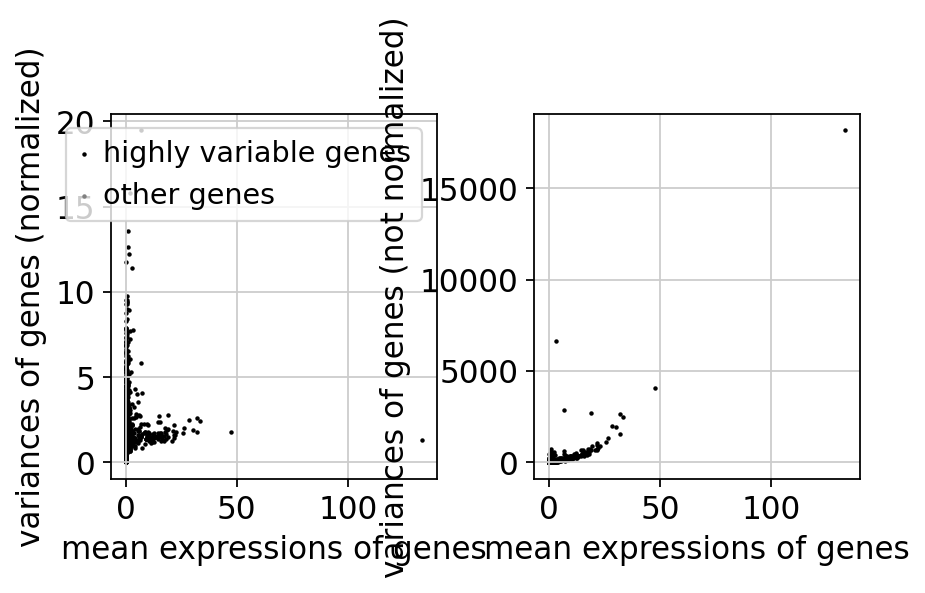

In [15]:
sc.set_figure_params(figsize=[3,3])
sc.pl.highly_variable_genes(AnnData_r)

# Move to GPU instance for SCVI

In [16]:
warnings.resetwarnings
scvi.model.SCVI.setup_anndata(AnnData_r, layer="counts", batch_key="batch", \
                        categorical_covariate_keys=["age_group",'study','chemistry','enrichment'])
vae = scvi.model.SCVI(AnnData_r,n_layers=2, n_latent=30,)
vae.train(max_epochs=300,batch_size=2000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████████████████| 300/300 [2:04:52<00:00, 25.88s/it, loss=1.02e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████████████████| 300/300 [2:04:52<00:00, 24.98s/it, loss=1.02e+03, v_num=1]


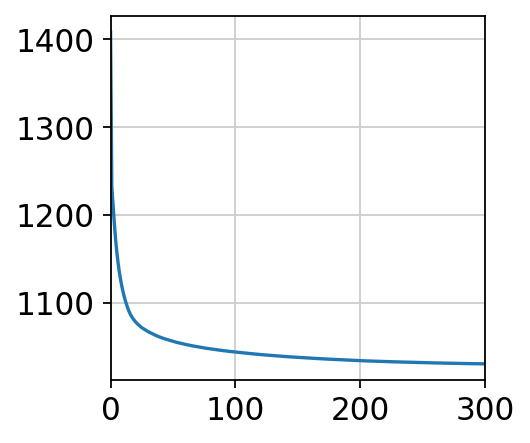

In [17]:
import matplotlib.pyplot as plt
plt.plot(vae.history['elbo_train'][:]);
plt.xlim(0, len(vae.history['elbo_train']));

In [34]:
AnnData.obsm["X_scVI"] = vae.get_latent_representation() # return batch corrections to original anndata
sc.pp.neighbors(AnnData, use_rep="X_scVI")

AnnData object with n_obs × n_vars = 655712 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'donor', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'cluster2'

In [45]:
AnnData.obs['backup_barcode'] = AnnData_new.obs.index
AnnData.obs.set_index('backup_barcode',inplace=True)
AnnData.obs.index.rename('barcode',inplace=True)

In [60]:
# AnnData.obs_names_make_unique()
AnnData.obs.index

Index(['F23_TH_45P-TACTTACCAAGGTGTG', 'F23_TH_45P-GTGCAGCTCACCGGGT',
       'F23_TH_45P-GAATAAGTCCTCGCAT', 'F23_TH_45P-CAACCAAAGTGAAGTT',
       'F23_TH_45P-ATTATCCAGAGTCTGG', 'F23_TH_45P-TCGTAGAAGGAATGGA',
       'F23_TH_45P-CCTTCGAAGCGATATA', 'F23_TH_45P-GGCTCGACACCTATCC',
       'F23_TH_45P-CAACTAGTCAACACCA', 'F23_TH_45P-ATCGAGTTCCGCATAA',
       ...
       'TA12303451-TAACCAGGTGAGAGGG', 'TA12303451-CATAAGCTCTTTGCGC',
       'TA12303451-GTATTTCAGAAGTCTA', 'TA12303451-TACACCCGTGTAACGG',
       'TA12303451-TTGGTTTGTCCAGTTA', 'TA12303451-TCTCCGAAGATGAAGG',
       'TA12303451-TTCAGGATCTAGTGTG', 'TA12303451-CGAAGGAGTCCTCATC',
       'TA12303451-TACCCGTGTGGCTGAA', 'TA12303451-GTGCACGGTTAGAGAT'],
      dtype='object', name='barcode', length=655712)

In [47]:
AnnData.obs['sample_barcode'] = AnnData.obs['sample_barcode'].astype('object')
# AnnData.obs['sample_barcode'][AnnData.obs['type'] == 'nuclei'] = AnnData.obs.index[AnnData.obs['type'] == 'nuclei']
AnnData.obs['sample_barcode'] = AnnData.obs['sample_barcode'].astype('category')


In [19]:
# sc.pp.pca(AnnData,n_comps=30)
sc.tl.umap(AnnData,min_dist=0.1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:14:13)


In [21]:
sc.set_figure_params(dpi=200,fontsize=10,)
sc.pl.umap(AnnData,color=['donor','pct_counts_mt','doublet_score','pct_counts_ribo'],size=0.5,cmap='jet',ncols=2,wspace=1)

In [27]:
sc.set_figure_params(dpi=200,fontsize=10,)
sc.pl.umap(AnnData,color=['louvian_05'],size=0.5,cmap='jet',ncols=2,wspace=1)

In [36]:
sc.set_figure_params(dpi=200,figsize=[10,10])
# sc.pl.umap(AnnData,color=['louvain_10'],size=0.5,cmap='jet',ncols=2,wspace=1)

# Get annotations form old object 

In [28]:
AnnAtlas = sc.read_h5ad('')

In [30]:
AnnAtlas

AnnData object with n_obs × n_vars = 386836 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'SampleID', 'barcode', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spliced', 'percent_top50_spliced', 'n_counts_unspliced', 'log1p_n_counts_unspliced', 'n_genes_unspliced', 'log1p_n_genes_unspliced', 'percent_mito_unspliced', 'n_counts_mito_unspliced', 'percent_ribo_unspliced', 'n_counts_ribo_unspliced', 'percent_hb_unsplic

In [31]:
# migrate annotations form old object 
for col in AnnAtlas.obs:
    if col not in AnnData.obs:
        AnnData.obs[col] = AnnAtlas.obs[col]


In [71]:
sc.set_figure_params(figsize=[10,10],fontsize=6)
sc.pl.umap(AnnData,color=['mapping_anno_v3','louvian_05','annotation_level_0'],size=2,cmap='jet',ncols=2,wspace=0.5,legend_loc='on data')

In [84]:
AnnData.write_h5ad('')